# 360-degree 3D Object Detection

In [1681]:
import argparse
import mmcv
import os
import torch
import warnings
import tempfile
import torch.distributed as dist
import shutil
import numpy as np
from torchvision import transforms
from PIL import Image
import glob

from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet3d.apis import single_gpu_test
from mmdet3d.datasets import build_dataset
from projects.mmdet3d_plugin.datasets.builder import build_dataloader
from mmdet3d.models import build_model
from mmdet.apis import set_random_seed
from projects.mmdet3d_plugin.bevformer.apis.test import custom_multi_gpu_test
from mmdet.datasets import replace_ImageToTensor
from mmdet3d.datasets.pipelines import Compose
from mmdet3d.core.bbox import get_box_type

import importlib
import time
import os.path as osp
from copy import deepcopy

from nuscenes.nuscenes import NuScenes
from PIL import Image

from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.eval.common.data_classes import EvalBoxes, EvalBox
from nuscenes.eval.detection.data_classes import DetectionBox
from nuscenes.eval.detection.utils import category_to_detection_name
from nuscenes.eval.detection.render import visualize_sample
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from matplotlib import rcParams
import matplotlib.pyplot as plt
from nuscenes.eval.common.utils import quaternion_yaw, Quaternion

In [3]:
def render_annotation(
        anntoken: str,
        margin: float = 10,
        view: np.ndarray = np.eye(4),
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        out_path: str = 'render.png',
        extra_info: bool = False) -> None:
    """
    Render selected annotation.
    :param anntoken: Sample_annotation token.
    :param margin: How many meters in each direction to include in LIDAR view.
    :param view: LIDAR view point.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param out_path: Optional path to save the rendered figure to disk.
    :param extra_info: Whether to render extra information below camera view.
    """
    ann_record = nusc.get('sample_annotation', anntoken)
    sample_record = nusc.get('sample', ann_record['sample_token'])
    assert 'LIDAR_TOP' in sample_record['data'].keys(), 'Error: No LIDAR_TOP in data, unable to render.'

    # Figure out which camera the object is fully visible in (this may return nothing).
    boxes, cam = [], []
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    all_bboxes = []
    select_cams = []
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                           selected_anntokens=[anntoken])
        if len(boxes) > 0:
            all_bboxes.append(boxes)
            select_cams.append(cam)
            # We found an image that matches. Let's abort.
    # assert len(boxes) > 0, 'Error: Could not find image where annotation is visible. ' \
    #                      'Try using e.g. BoxVisibility.ANY.'
    # assert len(boxes) < 2, 'Error: Found multiple annotations. Something is wrong!'

    num_cam = len(all_bboxes)

    fig, axes = plt.subplots(1, num_cam + 1, figsize=(18, 9))
    select_cams = [sample_record['data'][cam] for cam in select_cams]
    print('bbox in cams:', select_cams)
    # Plot LIDAR view.
    lidar = sample_record['data']['LIDAR_TOP']
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(lidar, selected_anntokens=[anntoken])
    LidarPointCloud.from_file(data_path).render_height(axes[0], view=view)
    for box in boxes:
        c = np.array(get_color(box.name)) / 255.0
        box.render(axes[0], view=view, colors=(c, c, c))
        corners = view_points(boxes[0].corners(), view, False)[:2, :]
        axes[0].set_xlim([np.min(corners[0, :]) - margin, np.max(corners[0, :]) + margin])
        axes[0].set_ylim([np.min(corners[1, :]) - margin, np.max(corners[1, :]) + margin])
        axes[0].axis('off')
        axes[0].set_aspect('equal')

    # Plot CAMERA view.
    for i in range(1, num_cam + 1):
        cam = select_cams[i - 1]
        data_path, boxes, camera_intrinsic = nusc.get_sample_data(cam, selected_anntokens=[anntoken])
        im = Image.open(data_path)
        axes[i].imshow(im)
        axes[i].set_title(nusc.get('sample_data', cam)['channel'])
        axes[i].axis('off')
        axes[i].set_aspect('equal')
        for box in boxes:
            c = np.array(get_color(box.name)) / 255.0
            box.render(axes[i], view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # Print extra information about the annotation below the camera view.
        axes[i].set_xlim(0, im.size[0])
        axes[i].set_ylim(im.size[1], 0)

    if extra_info:
        rcParams['font.family'] = 'monospace'

        w, l, h = ann_record['size']
        category = ann_record['category_name']
        lidar_points = ann_record['num_lidar_pts']
        radar_points = ann_record['num_radar_pts']

        sample_data_record = nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])
        pose_record = nusc.get('ego_pose', sample_data_record['ego_pose_token'])
        dist = np.linalg.norm(np.array(pose_record['translation']) - np.array(ann_record['translation']))

        information = ' \n'.join(['category: {}'.format(category),
                                  '',
                                  '# lidar points: {0:>4}'.format(lidar_points),
                                  '# radar points: {0:>4}'.format(radar_points),
                                  '',
                                  'distance: {:>7.3f}m'.format(dist),
                                  '',
                                  'width:  {:>7.3f}m'.format(w),
                                  'length: {:>7.3f}m'.format(l),
                                  'height: {:>7.3f}m'.format(h)])

        plt.annotate(information, (0, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    if out_path is not None:
        plt.savefig(out_path)

def get_sample_data(sample_data_token: str,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY,
                    selected_anntokens=None,
                    use_flat_vehicle_coordinates: bool = False):
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: Sample_data token.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: If provided only return the selected annotation.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                         aligned to z-plane in the world.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc.get_box, selected_anntokens))
    else:
        boxes = nusc.get_boxes(sample_data_token)

    # Make list of Box objects including coord system transforms.
    box_list = []
    for box in boxes:
        if use_flat_vehicle_coordinates:
            # Move box to ego vehicle coord system parallel to world z plane.
            yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        else:
            # Move box to ego vehicle coord system.
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(pose_record['rotation']).inverse)

            #  Move box to sensor coord system.
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)

    return data_path, box_list, cam_intrinsic


def lidiar_render(sample_token, data,out_path=None):
    bbox_gt_list = []
    bbox_pred_list = []
    anns = nusc.get('sample', sample_token)['anns']
    for ann in anns:
        content = nusc.get('sample_annotation', ann)
        try:
            bbox_gt_list.append(DetectionBox(
                sample_token=content['sample_token'],
                translation=tuple(content['translation']),
                size=tuple(content['size']),
                rotation=tuple(content['rotation']),
                velocity=nusc.box_velocity(content['token'])[:2],
                ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
                else tuple(content['ego_translation']),
                num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
                detection_name=category_to_detection_name(content['category_name']),
                detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
                attribute_name=''))
        except:
            pass

    bbox_anns = data['results'][sample_token]
    for content in bbox_anns:
        bbox_pred_list.append(DetectionBox(
            sample_token=content['sample_token'],
            translation=tuple(content['translation']),
            size=tuple(content['size']),
            rotation=tuple(content['rotation']),
            velocity=tuple(content['velocity']),
            ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
            else tuple(content['ego_translation']),
            num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
            detection_name=content['detection_name'],
            detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
            attribute_name=content['attribute_name']))
    gt_annotations = EvalBoxes()
    pred_annotations = EvalBoxes()
    gt_annotations.add_boxes(sample_token, bbox_gt_list)
    pred_annotations.add_boxes(sample_token, bbox_pred_list)
    print('green is ground truth')
    print('blue is the predited result')
    visualize_sample(nusc, sample_token, gt_annotations, pred_annotations, savepath=out_path+'_bev')


def get_color(category_name: str):
    """
    Provides the default colors based on the category names.
    This method works for the general nuScenes categories, as well as the nuScenes detection categories.
    """
    a = ['noise', 'animal', 'human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker',
     'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller',
     'human.pedestrian.wheelchair', 'movable_object.barrier', 'movable_object.debris',
     'movable_object.pushable_pullable', 'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle',
     'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.emergency.ambulance',
     'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck', 'flat.driveable_surface',
     'flat.other', 'flat.sidewalk', 'flat.terrain', 'static.manmade', 'static.other', 'static.vegetation',
     'vehicle.ego']
    class_names = [
        'car', 'truck', 'construction_vehicle', 'bus', 'trailer', 'barrier',
        'motorcycle', 'bicycle', 'pedestrian', 'traffic_cone'
    ]
    #print(category_name)
    if category_name == 'bicycle':
        return nusc.colormap['vehicle.bicycle']
    elif category_name == 'construction_vehicle':
        return nusc.colormap['vehicle.construction']
    elif category_name == 'traffic_cone':
        return nusc.colormap['movable_object.trafficcone']

    for key in nusc.colormap.keys():
        if category_name in key:
            return nusc.colormap[key]
    return [0, 0, 0]


def render_sample_data(
        sample_token: str,
        with_anns: bool = True,
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        axes_limit: float = 40,
        ax=None,
        nsweeps: int = 1,
        out_path: str = None,
        underlay_map: bool = True,
        use_flat_vehicle_coordinates: bool = True,
        show_lidarseg: bool = False,
        show_lidarseg_legend: bool = False,
        filter_lidarseg_labels=None,
        lidarseg_preds_bin_path: str = None,
        verbose: bool = True,
        show_panoptic: bool = False,
        pred_data=None,
      ) -> None:
    """
    Render sample data onto axis.
    :param sample_data_token: Sample_data token.
    :param with_anns: Whether to draw box annotations.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param axes_limit: Axes limit for lidar and radar (measured in meters).
    :param ax: Axes onto which to render.
    :param nsweeps: Number of sweeps for lidar and radar.
    :param out_path: Optional path to save the rendered figure to disk.
    :param underlay_map: When set to true, lidar data is plotted onto the map. This can be slow.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
        aligned to z-plane in the world. Note: Previously this method did not use flat vehicle coordinates, which
        can lead to small errors when the vertical axis of the global frame and lidar are not aligned. The new
        setting is more correct and rotates the plot by ~90 degrees.
    :param show_lidarseg: When set to True, the lidar data is colored with the segmentation labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
    :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
        or the list is empty, all classes will be displayed.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :param verbose: Whether to display the image after it is rendered.
    :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        If show_lidarseg is True, show_panoptic will be set to False.
    """
    lidiar_render(sample_token, pred_data, out_path=out_path)
    sample = nusc.get('sample', sample_token)
    # sample = data['results'][sample_token_list[0]][0]
    cams = [
        'CAM_FRONT_LEFT',
        'CAM_FRONT',
        'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT',
        'CAM_BACK',
        'CAM_BACK_RIGHT',
    ]
    if ax is None:
        _, ax = plt.subplots(4, 3, figsize=(24, 18))
    j = 0
    for ind, cam in enumerate(cams):
        sample_data_token = sample['data'][cam]

        sd_record = nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        # Load boxes and image.
        boxes = [Box(record['translation'], record['size'], Quaternion(record['rotation']), name=record['detection_name'], token='predicted') 
                 for record in pred_data['results'][sample_token] if record['detection_score'] > 0.2]

        data_path, boxes_pred, camera_intrinsic = get_predicted_data(sample_data_token, box_vis_level=box_vis_level, pred_anns=boxes)
        
        _, boxes_gt, _ = nusc.get_sample_data(sample_data_token, box_vis_level=box_vis_level)
        
        if ind == 3:
            j += 1
        ind = ind % 3
        data = Image.open(data_path)

        # Show image.
        ax[j, ind].imshow(data)
        ax[j + 2, ind].imshow(data)

        # Show boxes.
        if with_anns:
            for box in boxes_pred:
                c = np.array(get_color(box.name)) / 255.0
                box.render(ax[j, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))
            for box in boxes_gt:
                c = np.array(get_color(box.name)) / 255.0
                box.render(ax[j + 2, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # Limit visible range.
        ax[j, ind].set_xlim(0, data.size[0])
        ax[j, ind].set_ylim(data.size[1], 0)
        ax[j + 2, ind].set_xlim(0, data.size[0])
        ax[j + 2, ind].set_ylim(data.size[1], 0)

        ax[j, ind].axis('off')
        ax[j, ind].set_title('PRED: {} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax[j, ind].set_aspect('equal')

        ax[j + 2, ind].axis('off')
        ax[j + 2, ind].set_title('GT:{} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax[j + 2, ind].set_aspect('equal')

    if out_path is not None:
        plt.savefig(out_path+'_camera', bbox_inches='tight', pad_inches=0, dpi=200)
    if verbose:
        plt.show()
    plt.close()
    
def get_predicted_data(sample_data_token: str,
                       box_vis_level: BoxVisibility = BoxVisibility.ANY,
                       selected_anntokens=None,
                       use_flat_vehicle_coordinates: bool = False,
                       pred_anns=None
                       ):
    """
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: Sample_data token.
    :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: If provided only return the selected annotation.
    :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                         aligned to z-plane in the world.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

    data_path = nusc.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    # if selected_anntokens is not None:
    #    boxes = list(map(nusc.get_box, selected_anntokens))
    # else:
    #    boxes = nusc.get_boxes(sample_data_token)
    boxes = pred_anns
    # Make list of Box objects including coord system transforms.
    box_list = []
    for box in boxes:
        if use_flat_vehicle_coordinates:
            # Move box to ego vehicle coord system parallel to world z plane.
            yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        else:
            # Move box to ego vehicle coord system.
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(pose_record['rotation']).inverse)

            #  Move box to sensor coord system.
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue
        box_list.append(box)

    return data_path, box_list, cam_intrinsic

In [1898]:
rank, world_size = get_dist_info()

os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '2903'

# initialize the process group
dist.init_process_group("gloo", rank=rank, world_size=world_size)

RuntimeError: trying to initialize the default process group twice!

In [1682]:
config = './projects/configs/bevformer/bevformer_base.py'
ckpt = '../BEVFormer/ckpts/bevformer_r101_dcn_24ep.pth'

device = 'cuda:0'

cfg = Config.fromfile(config)

plugin_dir = cfg.plugin_dir
_module_dir = os.path.dirname(plugin_dir)
_module_dir = _module_dir.split('/')
_module_path = _module_dir[0]

for m in _module_dir[1:]:
    _module_path = _module_path + '.' + m
print(_module_path)
plg_lib = importlib.import_module(_module_path)

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

cfg.model.pretrained = None

samples_per_gpu = 1
cfg.data.test.test_mode = True
samples_per_gpu = cfg.data.test.pop('samples_per_gpu', 1)

projects.mmdet3d_plugin


In [1683]:
# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_model(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, ckpt, map_location='cpu')

model.CLASSES = checkpoint['meta']['CLASSES']
model.PALETTE = checkpoint['meta']['PALETTE']

# Built model to single CUDA device
if device is not 'cpu':
    torch.cuda.set_device(device)
model.to(device)
model.eval()

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/bevformer/modules/custom_base_transformer_layer.py:94: UserWarning: The arguments `feedforward_channels` in BaseTransformerLayer has been deprecated, now you should set `feedforward_channels` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/bevformer/modules/custom_base_transformer_layer.py:94: UserWarning: The arguments `ffn_dropout` in BaseTransformerLayer has been deprecated, now you should set `ffn_drop` and other FFN related arguments to a dict named `ffn_cfgs`. 
  warnings.warn(
/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/bevformer/modules/custom_base_transformer_layer.py:94: UserWarning: The arguments `ffn_num_fcs` in BaseTransformerLayer has been deprecated

load checkpoint from local path: ../BEVFormer/ckpts/bevformer_r101_dcn_24ep.pth


2022-11-14 06:21:58,610 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.0.conv2 is upgraded to version 2.
2022-11-14 06:21:58,614 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.1.conv2 is upgraded to version 2.
2022-11-14 06:21:58,617 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.2.conv2 is upgraded to version 2.
2022-11-14 06:21:58,620 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.3.conv2 is upgraded to version 2.
2022-11-14 06:21:58,623 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.4.conv2 is upgraded to version 2.
2022-11-14 06:21:58,626 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.5.conv2 is upgraded to version 2.
2022-11-14 06:21:58,628 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.6.conv2 is upgraded to version 2.
2022-11-14 06:21:58,631 - root - INFO - ModulatedDeformConvPack img_backbone.layer3.7.conv2 is upgraded to version 2.
2022-11-14 06:21:58,634 - root - INFO - ModulatedDeformC

BEVFormer(
  (pts_bbox_head): BEVFormerHead(
    (loss_cls): FocalLoss()
    (loss_bbox): L1Loss()
    (loss_iou): GIoULoss()
    (activate): ReLU(inplace=True)
    (positional_encoding): LearnedPositionalEncoding(num_feats=128, row_num_embed=200, col_num_embed=200)
    (transformer): PerceptionTransformer(
      (encoder): BEVFormerEncoder(
        (layers): ModuleList(
          (0): BEVFormerLayer(
            (attentions): ModuleList(
              (0): TemporalSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (sampling_offsets): Linear(in_features=512, out_features=128, bias=True)
                (attention_weights): Linear(in_features=512, out_features=64, bias=True)
                (value_proj): Linear(in_features=256, out_features=256, bias=True)
                (output_proj): Linear(in_features=256, out_features=256, bias=True)
              )
              (1): SpatialCrossAttention(
                (dropout): Dropout(p=0.1, inplace=False

In [1684]:
dataset = build_dataset(cfg.data.test)

data_loader = build_dataloader(
    dataset,
    samples_per_gpu=samples_per_gpu,
    workers_per_gpu=cfg.data.workers_per_gpu,
    # dist=False,
    dist=True,
    shuffle=False,
    nonshuffler_sampler=cfg.data.nonshuffler_sampler,
)

In [ ]:
nusc = NuScenes(version='v1.0-trainval', dataroot='./data/nuscenes', verbose=True)

# Insta360 Dataset Preparation

In [1984]:
# Change Data Input

"""Dataset 1. FOV (120, 120), Resolution 1000x1000"""
# tangent_patch_size = (1000, 1000)
# cur_frame = 'frame_0180.jpg'

# cur_filenames = ['./data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/3_front/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/4_front_right/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/2_front_left/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/0_back/'+cur_frame,
#                  './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/1_back_left/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/5_back_right/'+cur_frame]

# tangent_cams = ['./data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/2_front_left/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/3_front/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/4_front_right/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/1_back_left/'+cur_frame,
#                 './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/0_back/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_120fov_1000x1000/5_back_right/'+cur_frame]

# tangent_intrinsics = [[[474.43093925,0.,491.31570912],[0.,467.96789827,496.66222459],[0.,0.,1.]], # 2_front_left
#                       [[461.48071582,0.,485.52727853],[0.,456.69616035,506.9048758],[0.,0.,1.]], # 3_front
#                       [[648.91137487,0.,491.25631262],[0.,466.39633743,503.55409406],[0.,0.,1.]], # 4_front_right
#                       [[379.97547954,0.,474.94269824],[0.,399.33335026,448.14651339],[0.,0.,1.]], # 1_back_left
#                       [[473.91432417,0.,502.09118734],[0.,470.17266741,493.76922778], [0.,0.,1.]], # 0_back
#                       [[476.58560896,0.,489.02737013],[0.,474.43221528,497.28835466],[0.,0.,1.]]] # 5_back_right

"""Dataset 2. FOV (70, 70), Resolution 800x800"""
# tangent_patch_size = (800, 800)
# cur_frame = 'frame_0180.jpg'

# # Input
# cur_filenames = ['./data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/3_front/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/4_front_right/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/2_front_left/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/0_back/'+cur_frame,
#                  './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/1_back_left/'+cur_frame, 
#                  './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/5_back_right/'+cur_frame]
# # Visualization
# tangent_cams = ['./data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/2_front_left/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/3_front/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/4_front_right/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/1_back_left/'+cur_frame,
#                 './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/0_back/'+cur_frame, 
#                 './data/simple_road_outdoor_oct_23/tangent_patches_70fov_800x800/5_back_right/'+cur_frame]

# tangent_intrinsics = [[[656.24536467,0.,375.85853477],[0.,650.02567023,387.47207595],[0.,0.,1.]], # 2_front_left
#                       [[642.05847106,0.,386.48649006],[0.,634.39687303,389.69815667],[0.,0.,1.]], # 3_front
#                       [[495.57800473,0.,406.87866641],[0.,601.676778,302.86860227],[0.,0.,1.]], # 4_front_right
#                       [[518.16766045,0.,376.45885035],[0.,545.74779584,316.64273454],[0.,0.,1.]], # 1_back_left
#                       [[662.32537306,0.,397.04486038],[0.,656.71136718,398.44495815], [0.,0.,1.]], # 0_back
#                       [[641.31968424,0.,394.54743594],[0.,638.77832524,390.13875586],[0.,0.,1.]]] # 5_back_right

"""Dataset 2. FOV (70, 70), Resolution 800x800"""
tangent_patch_size = (1600, 900)
cur_frame = 'frame_0001.jpg'

# Input
cur_filenames = ['./data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/3_front/'+cur_frame, 
                 './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/4_front_right/'+cur_frame, 
                 './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/2_front_left/'+cur_frame, 
                 './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/0_back/'+cur_frame,
                 './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/1_back_left/'+cur_frame, 
                 './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/5_back_right/'+cur_frame]
# Visualization
tangent_cams = ['./data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/2_front_left/'+cur_frame, 
                './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/3_front/'+cur_frame, 
                './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/4_front_right/'+cur_frame, 
                './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/1_back_left/'+cur_frame,
                './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/0_back/'+cur_frame, 
                './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/5_back_right/'+cur_frame]

tangent_intrinsics_for_vis = [[[1326.72632, 0.0, 789.918136], [0.0, 1313.8785, 447.051964], [0.0, 0.0, 1.0]], # 2_front_left
                      [[1343.45019, 0.0, 820.183159], [0.0, 1280.23476, 442.850375], [0.0, 0.0, 1.0]], # 3_front
                      [[1318.58226, 0.0, 748.797979], [0.0, 1307.51676, 433.683573], [0.0, 0.0, 1.0]], # 4_front_right
                      [[1329.78802, 0.0, 794.247861], [0.0, 1318.65546, 422.083681], [0.0, 0.0, 1.0]], # 1_back_left
                      [[1318.10344, 0.0, 760.164664], [0.0, 1307.00893, 433.459504], [0.0, 0.0, 1.0]], # 0_back
                      [[1342.27544, 0.0, 790.251605], [0.0, 1326.28658, 452.853747], [0.0, 0.0, 1.0]]] # 5_back_right

tangent_intrinsics = {'CAM_FRONT': [[1343.45019, 0.0, 820.183159], [0.0, 1280.23476, 442.850375], [0.0, 0.0, 1.0]],
                      'CAM_FRONT_RIGHT': [[1318.58226, 0.0, 748.797979], [0.0, 1307.51676, 433.683573], [0.0, 0.0, 1.0]],
                      'CAM_FRONT_LEFT': [[1326.72632, 0.0, 789.918136], [0.0, 1313.8785, 447.051964], [0.0, 0.0, 1.0]],
                      'CAM_BACK': [[1318.10344, 0.0, 760.164664], [0.0, 1307.00893, 433.459504], [0.0, 0.0, 1.0]],
                      'CAM_BACK_LEFT': [[1329.78802, 0.0, 794.247861], [0.0, 1318.65546, 422.083681], [0.0, 0.0, 1.0]],
                      'CAM_BACK_RIGHT': [[1342.27544, 0.0, 790.251605], [0.0, 1326.28658, 452.853747], [0.0, 0.0, 1.0]]}

"""sample road scene video"""
# cur_frame = '0000630.png'
# cur_filenames = ['./data/insta360_sample_video/raw_data/tangent_images/3_front/'+cur_frame, './data/insta360_sample_video/raw_data/tangent_images/4_front_right/'+cur_frame, 
#              './data/insta360_sample_video/raw_data/tangent_images/2_front_left/'+cur_frame, './data/insta360_sample_video/raw_data/tangent_images/0_back/'+cur_frame,
#             './data/insta360_sample_video/raw_data/tangent_images/1_back_left/'+cur_frame, './data/insta360_sample_video/raw_data/tangent_images/5_back_right/'+cur_frame]

# tangent_cams = ['./data/insta360_sample_video/raw_data/tangent_images/2_front_left/'+cur_frame, './data/insta360_sample_video/raw_data/tangent_images/3_front/'+cur_frame, 
#              './data/insta360_sample_video/raw_data/tangent_images/4_front_right/'+cur_frame, './data/insta360_sample_video/raw_data/tangent_images/1_back_left/'+cur_frame,
#             './data/insta360_sample_video/raw_data/tangent_images/0_back/'+cur_frame, './data/insta360_sample_video/raw_data/tangent_images/5_back_right/'+cur_frame]

'sample road scene video'

## lidar2img 변경

### 방안 1. CAM_FRONT patch를 0도로 설정하고 +- 60 도씩 rotation

- `ego2front_rot = Quaternion(axis=[0, 0, 1], angle=0)` # Rotate 0 about Z (yaw): front cam을 기준으로 회전하므로 사용하지 않음
- `ego2front_right_rot = Quaternion(axis=[0, 0, 1], angle=np.pi / 3)` # Rotate 60 about Z (yaw)
- `ego2back_right_rot = Quaternion(axis=[0, 0, 1], angle=np.pi / 3 * 2)` # Rotate 120 about Z (yaw)
- `ego2back_rot = Quaternion(axis=[0, 0, 1], angle=np.pi)` # Rotate 180 about Z (yaw)
- `ego2back_left_rot = Quaternion(axis=[0, 0, 1], angle=-(np.pi / 3 * 2))` # Rotate -120 about Z (yaw)
- `ego2front_left_rot = Quaternion(axis=[0, 0, 1], angle=-(np.pi / 3))` # Rotate -60 about Z (yaw)


In [1957]:
"""lidar2img (insta360 setting에서는 ego cam 2 tangent patch) 변경"""

camera_types = ['CAM_FRONT','CAM_FRONT_RIGHT','CAM_FRONT_LEFT','CAM_BACK','CAM_BACK_LEFT','CAM_BACK_RIGHT']

front2cam_rotvecs = {'CAM_FRONT': Quaternion(axis=[0, 0, 1], angle=0),
                      'CAM_FRONT_RIGHT': Quaternion(axis=[0, 0, 1], angle=np.pi / 3),
                      'CAM_FRONT_LEFT': Quaternion(axis=[0, 0, 1], angle=-(np.pi / 3)),
                      'CAM_BACK': Quaternion(axis=[0, 0, 1], angle=np.pi),
                      'CAM_BACK_LEFT': Quaternion(axis=[0, 0, 1], angle=-(np.pi / 3 * 2)),
                      'CAM_BACK_RIGHT': Quaternion(axis=[0, 0, 1], angle=np.pi / 3 * 2)}

ego2patches = []
for i, cam in enumerate(camera_types):
    # insta360 ego cam => virtual tangent cam => tangent patch
    cam_intrinsic = np.array(tangent_intrinsics[cam])
    ego2cam_r = front2cam_rotvecs[cam]
    ego2cam_r_mat = Quaternion(ego2cam_r).rotation_matrix
    ego2cam_t = [0, 0, 0] # virtual cam <=> ego cam 거리 0
    
    ego2cam_rt = np.eye(4)
    ego2cam_rt[:3, :3] = ego2cam_r_mat
    ego2cam_rt[3, :3] = ego2cam_t
    
    viewpad = np.eye(4)
    viewpad[:cam_intrinsic.shape[0], :cam_intrinsic.shape[1]] = cam_intrinsic
    ego2patch = (viewpad @ ego2cam_rt)
    ego2patches.append(ego2patch)

ego2patches

[array([[1.34345019e+03, 0.00000000e+00, 8.20183159e+02, 0.00000000e+00],
        [0.00000000e+00, 1.28023476e+03, 4.42850375e+02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 6.59291130e+02, -1.14192573e+03,  7.48797979e+02,
          0.00000000e+00],
        [ 1.13234273e+03,  6.53758380e+02,  4.33683573e+02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 6.63363160e+02,  1.14897870e+03,  7.89918136e+02,
          0.00000000e+00],
        [-1.13785216e+03,  6.56939250e+02,  4.47051964e+02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 a

### 방안 2. cam intrinsics만 일단 변경

In [1985]:
"""lidar2img 변경"""
train_nusc_infos = []
val_nusc_infos = []
frame_idx = 0

sample = nusc.sample[0]

lidar_token = sample['data']['LIDAR_TOP']
sd_rec = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
pose_record = nusc.get('ego_pose', sd_rec['ego_pose_token'])
lidar_path, boxes, _ = nusc.get_sample_data(lidar_token)

mmcv.check_file_exist(lidar_path)

info = {
    'lidar_path': lidar_path,
    'token': sample['token'],
    'prev': sample['prev'],
    'next': sample['next'],
    'frame_idx': frame_idx,  # temporal related info
    'sweeps': [],
    'cams': dict(),
    'scene_token': sample['scene_token'],  # temporal related info
    'lidar2ego_translation': cs_record['translation'],
    'lidar2ego_rotation': cs_record['rotation'],
    'ego2global_translation': pose_record['translation'],
    'ego2global_rotation': pose_record['rotation'],
    'timestamp': sample['timestamp'],
}

if sample['next'] == '':
        frame_idx = 0
else:
    frame_idx += 1

l2e_r = info['lidar2ego_rotation']
l2e_t = info['lidar2ego_translation']
e2g_r = info['ego2global_rotation']
e2g_t = info['ego2global_translation']
l2e_r_mat = Quaternion(l2e_r).rotation_matrix # 3x3
e2g_r_mat = Quaternion(e2g_r).rotation_matrix

# obtain 6 image's information per frame
camera_types = [
    'CAM_FRONT',
    'CAM_FRONT_RIGHT',
    'CAM_FRONT_LEFT',
    'CAM_BACK',
    'CAM_BACK_LEFT',
    'CAM_BACK_RIGHT',
]
for cam in camera_types:
    cam_token = sample['data'][cam]
    cam_path, _, cam_intrinsic = nusc.get_sample_data(cam_token)

    # cam_info = obtain_sensor2top(nusc, cam_token, l2e_t, l2e_r_mat, e2g_t, e2g_r_mat, cam)
    sd_rec = nusc.get('sample_data', cam_token)
    cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', sd_rec['ego_pose_token'])
    data_path = str(nusc.get_sample_data_path(sd_rec['token']))
    if os.getcwd() in data_path:  # path from lyftdataset is absolute path
        data_path = data_path.split(f'{os.getcwd()}/')[-1]  # relative path
    cam_info = {
        'data_path': data_path,
        'type': cam_token,
        'sample_data_token': sd_rec['token'],
        'sensor2ego_translation': cs_record['translation'],
        'sensor2ego_rotation': cs_record['rotation'],
        'ego2global_translation': pose_record['translation'],
        'ego2global_rotation': pose_record['rotation'],
        'timestamp': sd_rec['timestamp']
    }

    l2e_r_s = cam_info['sensor2ego_rotation']
    l2e_t_s = cam_info['sensor2ego_translation']
    e2g_r_s = cam_info['ego2global_rotation']
    e2g_t_s = cam_info['ego2global_translation']

    # obtain the RT from sensor to Top LiDAR
    # cam->ego->global->ego'->lidar
    l2e_r_s_mat = Quaternion(l2e_r_s).rotation_matrix
    e2g_r_s_mat = Quaternion(e2g_r_s).rotation_matrix
    R = (l2e_r_s_mat.T @ e2g_r_s_mat.T) @ (
        np.linalg.inv(e2g_r_mat).T @ np.linalg.inv(l2e_r_mat).T)
    T = (l2e_t_s @ e2g_r_s_mat.T + e2g_t_s) @ (
        np.linalg.inv(e2g_r_mat).T @ np.linalg.inv(l2e_r_mat).T)
    T -= e2g_t @ (np.linalg.inv(e2g_r_mat).T @ np.linalg.inv(l2e_r_mat).T
                  ) + l2e_t @ np.linalg.inv(l2e_r_mat).T
    cam_info['sensor2lidar_rotation'] = R.T  # points @ R.T + T
    cam_info['sensor2lidar_translation'] = T

    cam_info.update(cam_intrinsic=cam_intrinsic)
    info['cams'].update({cam: cam_info})

lidar2img_rts = []
for cam_type, cam_info in info['cams'].items():
    # obtain lidar to image transformation matrix
    lidar2cam_r = np.linalg.inv(cam_info['sensor2lidar_rotation'])
    lidar2cam_t = cam_info['sensor2lidar_translation'] @ lidar2cam_r.T
    lidar2cam_rt = np.eye(4)
    lidar2cam_rt[:3, :3] = lidar2cam_r.T
    lidar2cam_rt[3, :3] = -lidar2cam_t
    
    # intrinsic = cam_info['cam_intrinsic']
    intrinsic = np.array(tangent_intrinsics[cam_type]) #@@@@@@@@@@@@@변경
    
    viewpad = np.eye(4)
    viewpad[:intrinsic.shape[0], :intrinsic.shape[1]] = intrinsic
    lidar2img_rt = (viewpad @ lidar2cam_rt.T)
    lidar2img_rts.append(lidar2img_rt)

lidar2img_rts

[array([[ 1.34896975e+03,  8.10679100e+02,  2.52753232e+01,
         -4.86170930e+02],
        [ 1.23690788e+01,  4.67103618e+02, -1.27152613e+03,
         -6.78708098e+02],
        [ 6.81137362e-03,  9.99795043e-01,  1.90650872e-02,
         -6.02145212e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 1.34617933e+03, -6.97290435e+02, -3.07385669e+01,
         -3.52572633e+02],
        [ 3.50564983e+02,  2.68598624e+02, -1.30485267e+03,
         -7.33597107e+02],
        [ 8.38549882e-01,  5.44801240e-01,  5.06993340e-03,
         -6.87326487e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 1.31945072e+02,  1.53795750e+03,  3.80868901e+01,
         -5.50734538e+02],
        [-3.58589010e+02,  2.92778038e+02, -1.30836811e+03,
         -7.08363380e+02],
        [-8.12372112e-01,  5.83027383e-01,  1.14290160e-02,
         -6.22061312e-01],
        [ 0.00000000e+00,  0.00000000e+

## Custom Sample Inference

In [1996]:
data_iterator = iter(data_loader)
model.prev_frame_info['prev_bev'] = None # 첫 inference로 세팅

In [1997]:
data = next(data_iterator)
data['img_metas'] = data['img_metas'][0].data
data['img'] = data['img'][0].data

print("CUR: ", data['img_metas'][0][0]['sample_idx'])
print("prev_idx: ", data['img_metas'][0][0]['prev_idx'])
print("next_idx: ", data['img_metas'][0][0]['next_idx'])

CUR:  30e55a3ec6184d8cb1944b39ba19d622
prev_idx:  
next_idx:  cc18fde20db74d30825b0b60ec511b7b


In [1998]:
results = {'img_filename': cur_filenames}

test_pipeline = cfg.data.test.pipeline
test_pipeline[3]['img_scale'] = tangent_patch_size
test_pipeline = Compose(test_pipeline)

cdata = test_pipeline(results)
cdata['img_metas'] = cdata['img_metas'][0].data
cdata['img'] = cdata['img'][0].data

In [1999]:
# Data loader에서 얻은 하나의 data를 custom data로 변경

# img_metas 변경
data['img_metas'][0][0]['filename'] = cdata['img_metas']['filename']
data['img_metas'][0][0]['ori_shape'] = cdata['img_metas']['ori_shape']
data['img_metas'][0][0]['img_shape'] = cdata['img_metas']['img_shape']
data['img_metas'][0][0]['pad_shape'] = cdata['img_metas']['pad_shape']
data['img_metas'][0][0]['scale_factor'] = cdata['img_metas']['scale_factor']
data['img_metas'][0][0]['flip'] = cdata['img_metas']['flip']
data['img_metas'][0][0]['pcd_horizontal_flip'] = cdata['img_metas']['pcd_horizontal_flip']
data['img_metas'][0][0]['pcd_vertical_flip'] = cdata['img_metas']['pcd_vertical_flip']
data['img_metas'][0][0]['img_norm_cfg'] = cdata['img_metas']['img_norm_cfg']
data['img_metas'][0][0]['pcd_scale_factor'] = cdata['img_metas']['pcd_scale_factor']

# img tensors 변경
data['img'] = [cdata['img'][None, :]]

# lidar2img 변경 (array 순서: front, front_right, front_left, back, back_left, back_right)

# data['img_metas'][0][0]['lidar2img'] = ego2patches
# data['img_metas'][0][0]['lidar2img'] = lidar2img_rts

# TODO: pose 및 frame sequence (prev, next) 관련

## Ego-pose Data 변경 (can_bus)
### ORB_SLAM3로 얻은 pose 활용
ORB SLAM trajectory file ==> t_x, t_y, t_z, quaternion_x, quaternion_y, quaternion_z, quaternion_w

pyquaternion ==> Quaternion(w, x, y, z)

In [1877]:
"""Can_bus 변경 임시"""
rotation = Quaternion([0.999514282, -0.009492505, -0.029651314, 0.001394546])

"""nuscenes: x가 차 전진 방향, y는 차량 좌우 방향, z는 차 위아래 방향"""
translation = [-0.008222580, -0.006377218, 0.040763527]
"""insta: z가 전진 방향, y는 좌우 방향, x는 위아래 방향 (z, y, x)"""
# translation = [0.040763527, -0.006377218, -0.008222580]

data['img_metas'][0][0]['can_bus'][:3] = translation
data['img_metas'][0][0]['can_bus'][3:7] = rotation

patch_angle = quaternion_yaw(rotation) / np.pi * 180 # we get the yaw angle of ego car
if patch_angle < 0:
    patch_angle += 360
data['img_metas'][0][0]['can_bus'][-2] = patch_angle / 180 * np.pi # this angle is kept unchanged.
data['img_metas'][0][0]['can_bus'][-1] = patch_angle # this angle is used to compute the detal of adjacent timestamps.

In [1860]:
data['img_metas'][0][0]

{'filename': ['./data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/3_front/frame_0001.jpg',
  './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/4_front_right/frame_0001.jpg',
  './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/2_front_left/frame_0001.jpg',
  './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/0_back/frame_0001.jpg',
  './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/1_back_left/frame_0001.jpg',
  './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/5_back_right/frame_0001.jpg'],
 'ori_shape': [(900, 1600, 3),
  (900, 1600, 3),
  (900, 1600, 3),
  (900, 1600, 3),
  (900, 1600, 3),
  (900, 1600, 3)],
 'img_shape': [(928, 1600, 3),
  (928, 1600, 3),
  (928, 1600, 3),
  (928, 1600, 3),
  (928, 1600, 3),
  (928, 1600, 3)],
 'lidar2img': [array([[1.34345019e+03, 0.00000000e+00, 8.20183159e+02, 0.00000000e+00],
         [0.00000000e+00, 1.28023476e+03, 4.42850375e+02, 0.

In [2000]:
bbox_results = []
mask_results = []
rank, world_size = get_dist_info()
have_mask = False

with torch.no_grad():
    
    data['img'][0] = data['img'][0].to(device)
    result = model(return_loss=False, rescale=True, **data)

    # encode mask results
    if isinstance(result, dict):
        if 'bbox_results' in result.keys():
            bbox_result = result['bbox_results']
            batch_size = len(result['bbox_results'])
            bbox_results.extend(bbox_result)
        if 'mask_results' in result.keys() and result['mask_results'] is not None:
            mask_result = custom_encode_mask_results(result['mask_results'])
            mask_results.extend(mask_result)
            have_mask = True
            print("have mask")
    else:
        batch_size = len(result)
        bbox_results.extend(result)
    
# Collect results
MAX_LEN = 512
size = len(dataset)

# 32 is whitespace
dir_tensor = torch.full((MAX_LEN, ), 32, dtype=torch.uint8, device=device)
if rank == 0:
    mmcv.mkdir_or_exist('.dist_test')
    tmpdir = tempfile.mkdtemp(dir='.dist_test')
    tmpdir = torch.tensor(
        bytearray(tmpdir.encode()), dtype=torch.uint8, device=device)
    dir_tensor[:len(tmpdir)] = tmpdir

dist.broadcast(dir_tensor, 0)
tmpdir = dir_tensor.cpu().numpy().tobytes().decode().rstrip()

# dump the part result to the dir
mmcv.dump(bbox_results, osp.join(tmpdir, f'part_{rank}.pkl'))
dist.barrier()

new_bbox_results = []

# collect all parts
if rank == 0:
    # load results of all parts from tmp dir
    part_list = []
    for i in range(world_size):
        part_file = osp.join(tmpdir, f'part_{i}.pkl')
        part_list.append(mmcv.load(part_file))

    # sort the results
    '''
    bacause we change the sample of the evaluation stage to make sure that each gpu will handle continuous sample,
    '''
    #for res in zip(*part_list):
    for res in part_list:
        new_bbox_results.extend(list(res))
    # the dataloader may pad some samples
    new_bbox_results = new_bbox_results[:size]
    # remove tmp dir
    shutil.rmtree(tmpdir)

# return
outputs = {'bbox_results': new_bbox_results, 'mask_results': None}
len(outputs['bbox_results'])

/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/core/bbox/coders/nms_free_coder.py:57: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bbox_index = indexs // self.num_classes
/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/core/bbox/coders/nms_free_coder.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


1

In [ ]:
new_bbox_results

In [2001]:
# Write Results into File
mmcv.dump(outputs['bbox_results'], './output.pkl')

jsonfile_prefix = osp.join('simple_road_scene_results', config.split('/')[-1].split('.')[-2], time.ctime().replace(' ', '_').replace(':', '_'))

result_files = dict()
for name in outputs['bbox_results'][0]:
    print(f'\nFormating bboxes of {name}')
    results_ = [out[name] for out in outputs['bbox_results']]
    tmp_file_ = osp.join(jsonfile_prefix, name)
    result_files.update({name: dataset._format_bbox(results_, tmp_file_)})

bevformer_results = mmcv.load(jsonfile_prefix+'/pts_bbox/results_nusc.json')


Formating bboxes of pts_bbox
Start to convert detection format...
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 8.8 task/s, elapsed: 0s, ETA:     0s
Results writes to simple_road_scene_results/bevformer_base/Wed_Nov_16_21_14_45_2022/pts_bbox/results_nusc.json


@@@@@@@@@@@ CAM:  CAM_FRONT_LEFT
Boxes in camera viewport [label: nan, score: nan, xyz: [-0.78, 0.74, 9.57], wlh: [4.36, 1.81, 1.57], rot axis: [0.43, -0.63, 0.65], ang(degrees): 134.25, ang(rad): 2.34, vel: nan, nan, nan, name: car, token: predicted, label: nan, score: nan, xyz: [16.44, 0.47, 26.24], wlh: [4.77, 1.98, 1.86], rot axis: [0.35, -0.65, 0.67], ang(degrees): 141.93, ang(rad): 2.48, vel: nan, nan, nan, name: car, token: predicted]

@@@@@@@@@@@ CAM:  CAM_FRONT
Boxes in camera viewport [label: nan, score: nan, xyz: [-12.45, 0.28, 28.32], wlh: [4.77, 1.98, 1.86], rot axis: [0.01, -0.70, 0.71], ang(degrees): 179.57, ang(rad): 3.13, vel: nan, nan, nan, name: car, token: predicted]

@@@@@@@@@@@ CAM:  CAM_FRONT_RIGHT
Boxes in camera viewport []

@@@@@@@@@@@ CAM:  CAM_BACK_LEFT
Boxes in camera viewport [label: nan, score: nan, xyz: [-0.86, 0.48, 13.18], wlh: [4.32, 1.82, 1.66], rot axis: [-0.69, 0.51, -0.51], ang(degrees): -112.97, ang(rad): -1.97, vel: nan, nan, nan, name: car, tok

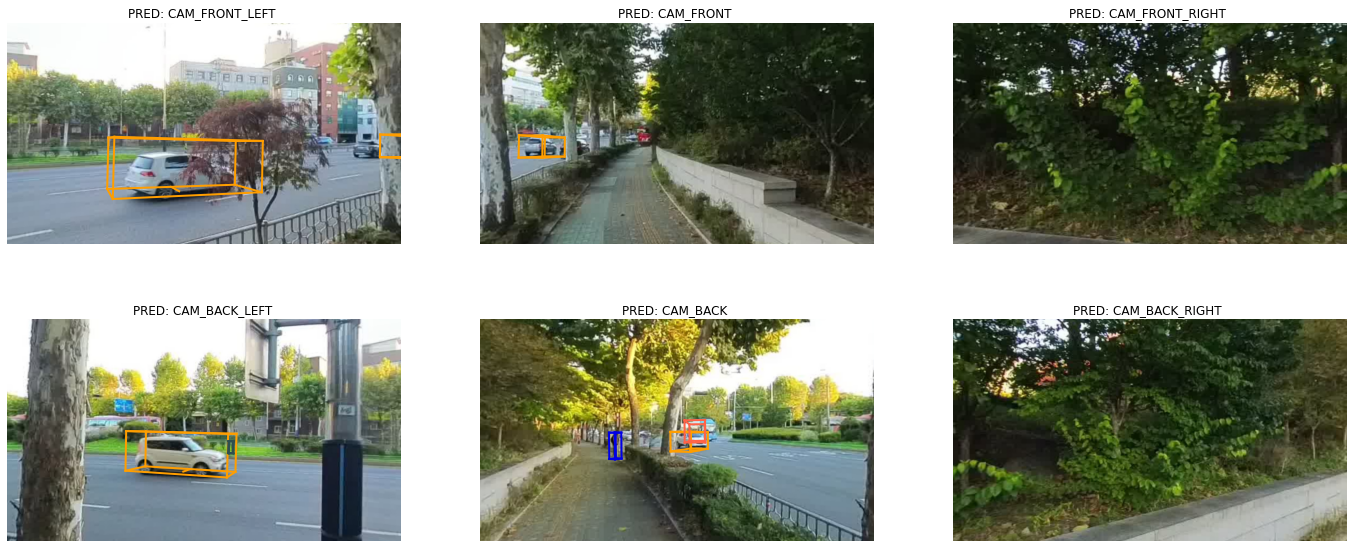

In [2003]:
# render_annotation('7603b030b42a4b1caa8c443ccc1a7d52')
sample_token_list = list(bevformer_results['results'].keys())
# for id in range(0, 1):

id = 0
sample_token=sample_token_list[id]
pred_data=bevformer_results
out_path=sample_token_list[id]

use_flat_vehicle_coordinates = False
score_threshold = 0.3

with_anns = True
box_vis_level = BoxVisibility.ANY
axes_limit = 40
ax=None
nsweeps = 1
underlay_map = True
show_lidarseg = False
show_lidarseg_legend = False
filter_lidarseg_labels=None
lidarseg_preds_bin_path = None
verbose = True
show_panoptic = False

cams = [
    'CAM_FRONT_LEFT',
    'CAM_FRONT',
    'CAM_FRONT_RIGHT',
    'CAM_BACK_LEFT',
    'CAM_BACK',
    'CAM_BACK_RIGHT',
]

sample = nusc.get('sample', sample_token)

if ax is None:
    _, ax = plt.subplots(2, 3, figsize=(24, 10))
    # _, ax = plt.subplots(4, 3, figsize=(24, 18))
    
j = 0
for ind, cam in enumerate(cams):
    print("@@@@@@@@@@@ CAM: ", cam)
    sample_data_token = sample['data'][cam]

    sd_record = nusc.get('sample_data', sample_data_token)
    sensor_modality = sd_record['sensor_modality']

    # Load boxes and image.
    boxes = [Box(record['translation'], record['size'], Quaternion(record['rotation']), name=record['detection_name'], token='predicted') 
             for record in pred_data['results'][sample_token] if record['detection_score'] > score_threshold]
    
    # print("Predicted boxes", boxes)

    """
    get predicted data - START
    
    Returns the data path as well as all annotations related to that sample_data.
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
    """
    # Retrieve sensor & pose records
    sd_record = nusc.get('sample_data', sample_data_token)
    cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc.get('sensor', cs_record['sensor_token'])
    pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])
    data_path = nusc.get_sample_data_path(sample_data_token)
    camera_intrinsic = np.array(cs_record['camera_intrinsic'])
    imsize = (sd_record['width'], sd_record['height'])

    # nusc => tangent cam으로 변경
    data_path = tangent_cams[ind]
    # camera_intrinsic = np.array(tangent_intrinsics_for_vis[ind])
    imsize = tangent_patch_size
    
    # print("data path", data_path)
    # print("cam instrinsic", camera_intrinsic)
    # print("img size", imsize)

    # Make list of Box objects including coord system transforms.
    boxes_pred = []
    for box in boxes:
        if use_flat_vehicle_coordinates:
            # Move box to ego vehicle coord system parallel to world z plane.
            yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        else:
            # print("Current box before translation", box)
            
            """기존 nuscenes"""
            # Move box to ego vehicle coord system. (pose record: ego2global)
            box.translate(-np.array(pose_record['translation']))
            box.rotate(Quaternion(pose_record['rotation']).inverse)
            
            # print("global2ego", -np.array(pose_record['translation']), Quaternion(pose_record['rotation']).inverse)
            # print("Current box after moving to ego coord system", box)
            
            #  Move box to sensor coord system. (cs_record: sensor2ego)
            box.translate(-np.array(cs_record['translation']))
            box.rotate(Quaternion(cs_record['rotation']).inverse)
            
            # print("ego2sensor", -np.array(cs_record['translation']), Quaternion(cs_record['rotation']).inverse)
            # print("Current box after moving to camera coord system", box)
            # print()
            
            
            """insta360"""
            # Move box to ego vehicle coord system. (pose record: ego2global)
            # ORB_SLAM이 ego2global인지 확인 (+/- 바꿔보기)
            
            # box.translate(-np.array(translation))
            # box.rotate(rotation.inverse)

            #  Move box to sensor coord system. 
            # nuscenes에서는 cs_record: sensor2ego, insta360에서는 egocam2tangentcam으로 R 만 존재
            # box.rotate(front2cam_rotvecs[cam])
            
            # print("insta360")
            # print("global2ego", -np.array([-0.062425584, -0.002085830, 0.344779789]), Quaternion([0.998749077, -0.013452108, -0.043297615, 0.021088535]).inverse)
            # print()
            

        if not box_in_image(box, camera_intrinsic, imsize, vis_level=box_vis_level):
            continue

        boxes_pred.append(box)

    """get predicted data - END"""

    print("Boxes in camera viewport", boxes_pred)
    print()

    if ind == 3:
        j += 1
    ind = ind % 3
    img_data = Image.open(data_path)

    # Show image.
    ax[j, ind].imshow(img_data)

    # Show boxes.
    if with_anns:
        for box in boxes_pred:
            c = np.array(get_color(box.name)) / 255.0
            box.render(ax[j, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))

    # Limit visible range.
    ax[j, ind].set_xlim(0, img_data.size[0])
    ax[j, ind].set_ylim(img_data.size[1], 0)

    ax[j, ind].axis('off')
    ax[j, ind].set_title('PRED: {} {labels_type}'.format(
        sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
    ax[j, ind].set_aspect('equal')

    
plt.savefig('./pred_results_' + cur_frame, bbox_inches='tight', pad_inches=0, dpi=200)
plt.show()
plt.close()

# GT Vis
# render_sample_data(sample_token_list[0], pred_data=bevformer_results, out_path=sample_token_list[0])

# 모든 frame에 대한 prediction 결과 이미지 저장

frame_0001.jpg
Start to convert detection format...
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 14.9 task/s, elapsed: 0s, ETA:     0s

/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/core/bbox/coders/nms_free_coder.py:57: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bbox_index = indexs // self.num_classes
/data/home/jeholee/omni3D/bev_based/BEVFormer/projects/mmdet3d_plugin/core/bbox/coders/nms_free_coder.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(



Results writes to simple_road_scene_results/bevformer_base/Tue_Nov_15_20_22_49_2022/pts_bbox/results_nusc.json


KeyboardInterrupt: 

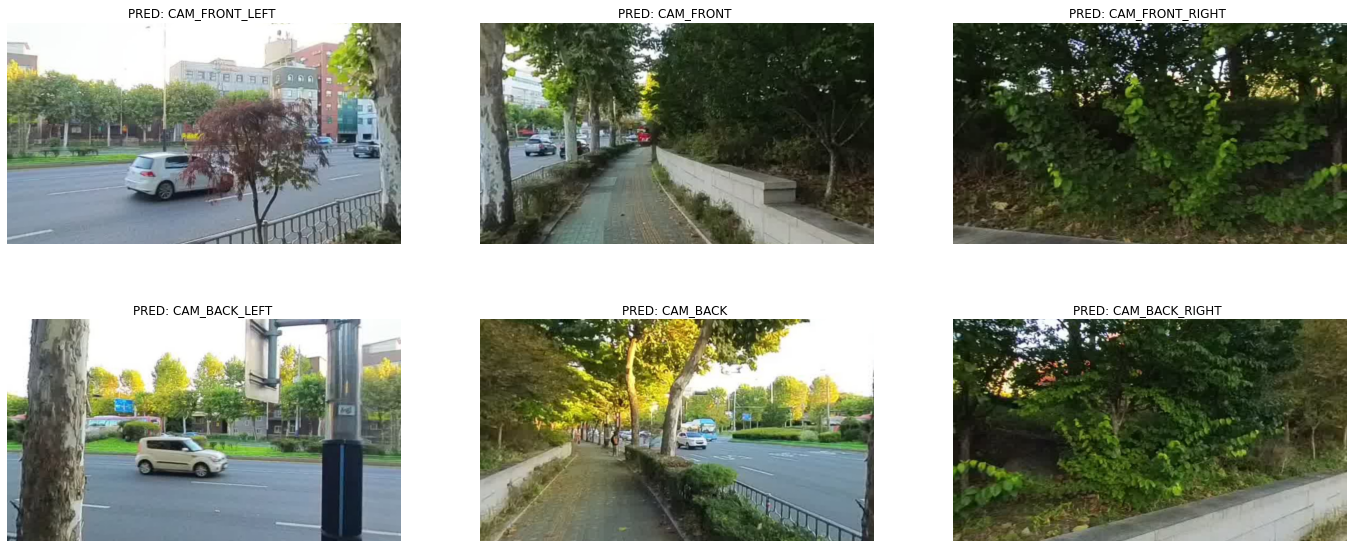

In [1886]:
images = glob.glob('./data/simple_road_outdoor_oct_23/erp/*.jpg')
images = sorted(images)

for image in images:
    
    cur_frame = os.path.basename(image)
    print(cur_frame)
    
    # Input
    cur_filenames = ['./data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/3_front/'+cur_frame, 
                     './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/4_front_right/'+cur_frame, 
                     './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/2_front_left/'+cur_frame, 
                     './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/0_back/'+cur_frame,
                     './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/1_back_left/'+cur_frame, 
                     './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/5_back_right/'+cur_frame]
    # Visualization
    tangent_cams = ['./data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/2_front_left/'+cur_frame, 
                    './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/3_front/'+cur_frame, 
                    './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/4_front_right/'+cur_frame, 
                    './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/1_back_left/'+cur_frame,
                    './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/0_back/'+cur_frame, 
                    './data/simple_road_outdoor_oct_23/tangent_patches_70x39fov_1600x900/5_back_right/'+cur_frame]
    
    data_iterator = iter(data_loader)

    data = next(data_iterator)
    data['img_metas'] = data['img_metas'][0].data
    data['img'] = data['img'][0].data

    results = {'img_filename': cur_filenames}

    test_pipeline = cfg.data.test.pipeline
    test_pipeline[3]['img_scale'] = tangent_patch_size
    test_pipeline = Compose(test_pipeline)

    cdata = test_pipeline(results)
    cdata['img_metas'] = cdata['img_metas'][0].data
    cdata['img'] = cdata['img'][0].data


    # Data loader에서 얻은 하나의 data를 custom data로 변경

    # img_metas 변경
    data['img_metas'][0][0]['filename'] = cdata['img_metas']['filename']
    data['img_metas'][0][0]['ori_shape'] = cdata['img_metas']['ori_shape']
    data['img_metas'][0][0]['img_shape'] = cdata['img_metas']['img_shape']
    data['img_metas'][0][0]['pad_shape'] = cdata['img_metas']['pad_shape']
    data['img_metas'][0][0]['scale_factor'] = cdata['img_metas']['scale_factor']
    data['img_metas'][0][0]['flip'] = cdata['img_metas']['flip']
    data['img_metas'][0][0]['pcd_horizontal_flip'] = cdata['img_metas']['pcd_horizontal_flip']
    data['img_metas'][0][0]['pcd_vertical_flip'] = cdata['img_metas']['pcd_vertical_flip']
    data['img_metas'][0][0]['img_norm_cfg'] = cdata['img_metas']['img_norm_cfg']
    data['img_metas'][0][0]['pcd_scale_factor'] = cdata['img_metas']['pcd_scale_factor']

    # img tensors 변경
    data['img'] = [cdata['img'][None, :]]
    
    # lidar2img 변경 (array 순서: front, front_right, front_left, back, back_left, back_right)
    # data['img_metas'][0][0]['lidar2img'] = ego2patches

    """@@@@@@@@ TODO @@@@@@@@"""
    # TODO: pose 및 frame sequence (prev, next) 관련

    bbox_results = []
    mask_results = []
    rank, world_size = get_dist_info()
    have_mask = False

    with torch.no_grad():

        data['img'][0] = data['img'][0].to(device)
        result = model(return_loss=False, rescale=True, **data)

        # encode mask results
        if isinstance(result, dict):
            if 'bbox_results' in result.keys():
                bbox_result = result['bbox_results']
                batch_size = len(result['bbox_results'])
                bbox_results.extend(bbox_result)
            if 'mask_results' in result.keys() and result['mask_results'] is not None:
                mask_result = custom_encode_mask_results(result['mask_results'])
                mask_results.extend(mask_result)
                have_mask = True
        else:
            batch_size = len(result)
            bbox_results.extend(result)

    # Collect results
    MAX_LEN = 512
    size = len(dataset)

    # 32 is whitespace
    dir_tensor = torch.full((MAX_LEN, ), 32, dtype=torch.uint8, device=device)
    if rank == 0:
        mmcv.mkdir_or_exist('.dist_test')
        tmpdir = tempfile.mkdtemp(dir='.dist_test')
        tmpdir = torch.tensor(
            bytearray(tmpdir.encode()), dtype=torch.uint8, device=device)
        dir_tensor[:len(tmpdir)] = tmpdir

    dist.broadcast(dir_tensor, 0)
    tmpdir = dir_tensor.cpu().numpy().tobytes().decode().rstrip()

    # dump the part result to the dir
    mmcv.dump(bbox_results, osp.join(tmpdir, f'part_{rank}.pkl'))
    dist.barrier()

    new_bbox_results = []

    # collect all parts
    if rank == 0:
        # load results of all parts from tmp dir
        part_list = []
        for i in range(world_size):
            part_file = osp.join(tmpdir, f'part_{i}.pkl')
            part_list.append(mmcv.load(part_file))

        # sort the results
        '''
        bacause we change the sample of the evaluation stage to make sure that each gpu will handle continuous sample,
        '''
        #for res in zip(*part_list):
        for res in part_list:
            new_bbox_results.extend(list(res))
        # the dataloader may pad some samples
        new_bbox_results = new_bbox_results[:size]
        # remove tmp dir
        shutil.rmtree(tmpdir)

    # return
    outputs = {'bbox_results': new_bbox_results, 'mask_results': None}

    # Write Results into File
    mmcv.dump(outputs['bbox_results'], './output.pkl')

    jsonfile_prefix = osp.join('simple_road_scene_results', config.split('/')[-1].split('.')[-2], time.ctime().replace(' ', '_').replace(':', '_'))

    result_files = dict()
    for name in outputs['bbox_results'][0]:
        results_ = [out[name] for out in outputs['bbox_results']]
        tmp_file_ = osp.join(jsonfile_prefix, name)
        result_files.update({name: dataset._format_bbox(results_, tmp_file_)})

    bevformer_results = mmcv.load(jsonfile_prefix+'/pts_bbox/results_nusc.json')

    # render_annotation('7603b030b42a4b1caa8c443ccc1a7d52')
    sample_token_list = list(bevformer_results['results'].keys())
    # for id in range(0, 1):

    id = 0
    sample_token=sample_token_list[id]
    pred_data=bevformer_results
    out_path=sample_token_list[id]

    use_flat_vehicle_coordinates = False
    score_threshold = 0.2

    with_anns = True
    box_vis_level = BoxVisibility.ANY
    axes_limit = 40
    ax=None
    nsweeps = 1
    underlay_map = True
    show_lidarseg = False
    show_lidarseg_legend = False
    filter_lidarseg_labels=None
    lidarseg_preds_bin_path = None
    verbose = True
    show_panoptic = False

    cams = [
        'CAM_FRONT_LEFT',
        'CAM_FRONT',
        'CAM_FRONT_RIGHT',
        'CAM_BACK_LEFT',
        'CAM_BACK',
        'CAM_BACK_RIGHT',
    ]

    sample = nusc.get('sample', sample_token)

    if ax is None:
        _, ax = plt.subplots(2, 3, figsize=(24, 10))
        # _, ax = plt.subplots(4, 3, figsize=(24, 18))

    j = 0
    for ind, cam in enumerate(cams):
        sample_data_token = sample['data'][cam]

        sd_record = nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        # Load boxes and image.
        boxes = [Box(record['translation'], record['size'], Quaternion(record['rotation']), name=record['detection_name'], token='predicted') 
                 for record in pred_data['results'][sample_token] if record['detection_score'] > score_threshold]

        # print("Predicted boxes", boxes)

        """get predicted data - START"""
        # data_path, boxes_pred, camera_intrinsic = get_predicted_data(sample_data_token, box_vis_level=box_vis_level, pred_anns=boxes)

        # Retrieve sensor & pose records
        sd_record = nusc.get('sample_data', sample_data_token)
        cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
        sensor_record = nusc.get('sensor', cs_record['sensor_token'])
        pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

        data_path = nusc.get_sample_data_path(sample_data_token)
        camera_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])

        # nusc => tangent cam으로 변경
        data_path = tangent_cams[ind]
        camera_intrinsic = np.array(tangent_intrinsics_for_vis[ind])
        imsize = tangent_patch_size

        # Make list of Box objects including coord system transforms.
        boxes_pred = []
        for box in boxes:
            if use_flat_vehicle_coordinates:
                # Move box to ego vehicle coord system parallel to world z plane.
                yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
            else:
                # Move box to ego vehicle coord system.
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(pose_record['rotation']).inverse)

                #  Move box to sensor coord system.
                box.translate(-np.array(cs_record['translation']))
                box.rotate(Quaternion(cs_record['rotation']).inverse)

            if not box_in_image(box, camera_intrinsic, imsize, vis_level=box_vis_level):
                continue

            boxes_pred.append(box)


        if ind == 3:
            j += 1
        ind = ind % 3
        data = Image.open(data_path)

        # Show image.
        ax[j, ind].imshow(data)

        # Show boxes.
        if with_anns:
            for box in boxes_pred:
                c = np.array(get_color(box.name)) / 255.0
                box.render(ax[j, ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # Limit visible range.
        ax[j, ind].set_xlim(0, data.size[0])
        ax[j, ind].set_ylim(data.size[1], 0)

        ax[j, ind].axis('off')
        ax[j, ind].set_title('PRED: {} {labels_type}'.format(
            sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
        ax[j, ind].set_aspect('equal')


    plt.savefig('./pred_results/' + cur_frame, bbox_inches='tight', pad_inches=0, dpi=200)
    # plt.show()
    plt.close()

    # GT Vis
    # render_sample_data(sample_token_list[0], pred_data=bevformer_results, out_path=sample_token_list[0])

# nuScenes meta-data 설명 및 사용되는 과정

### nuScenes dataset creation
- create_dataset.py => nuscenes_converter.py in tools/
- Can_bus data가 준비되는 시점

### nuScenes dataset input preparation
- CustomNuScenesDataset class => nuscenes_dataset.py in BEVFormer.projects.mmdet3d_plugin.dataset
- can_bus data를 재구성하고, lidar2img가 준비되는 시점

### Test pipeline

- Can_bus
    - bevformer/detectors/bevformer.py => forward_test()
        - delta orientation and position of adjacent timestamps를 can_bus에 저장
    - bevformer/modules/transformer.py => get_bev_features()
        - inter-frame간 2d bev planes가 얼만큼 이동했는지 계산 => shift 변수
    - bevformer/modules/encoder.py => forward()
        - 2d bev plane의 2d reference points를 위에서 계산한 shift만큼 이동시킴
___
- lidar2img
    - bevformer/modules/encoder.py => point_sampling()
    
___
`can_bus`
- can_bus[:3] => ego-pose (ego2global translation)
- can_bus[3:7] => ego-rotation (ego2global rotation)
- can_bus[-1], can_bus[-2] => car yaw angle (2d bev plane은 yaw angle 즉 왼쪽 오른쪽 회전이 중요)

`lidar2img`
- 현재 시점에서 lidar coordinate system에서 6개의 카메라 image plane으로의 변환 행렬
- 

In [1022]:
data_iterator = iter(data_loader)

In [1190]:
data = next(data_iterator)
data['img_metas'] = data['img_metas'][0].data
data['img'] = data['img'][0].data

print("CUR: ", data['img_metas'][0][0]['sample_idx'])
print("prev_idx: ", data['img_metas'][0][0]['prev_idx'])
print("next_idx: ", data['img_metas'][0][0]['next_idx'])

can_bus = data['img_metas'][0][0]['can_bus']

CUR:  9de41b523cce4fb3aa4f6230ec06345d
prev_idx:  cf6a7d894c034a4db251f41bc31cdbf7
next_idx:  5bbe677b299143128aa0492add6b28cf


0번째 data sample

In [1191]:
""" prev_pos """
prev_pos = can_bus[:3]
print(prev_pos)

[ 612.95000048 1452.05048524    0.        ]


In [1192]:
""" prev_angle """
prev_angle = can_bus[-1] # car yaw angle
print(prev_angle)

73.32828913967323


1번째 data sample에서 0번째 (이전) data와의 pose 차이 계산

In [1193]:
# next data
data_1 = next(data_iterator)
data_1['img_metas'] = data_1['img_metas'][0].data
data_1['img'] = data_1['img'][0].data

can_bus_1 = data_1['img_metas'][0][0]['can_bus']

In [1194]:
can_bus_1[:3] -= prev_pos
can_bus_1[-1] -= prev_angle # car yaw angle

In [1195]:
delta_x = np.array(can_bus_1[0])
delta_y = np.array(can_bus_1[1])
print("delta translation", delta_x, delta_y)

delta translation 0.09405770690977988 0.29950274406337485


In [1196]:
ego_angle = np.array(can_bus_1[-2] / np.pi * 180) # 현재 car의 angle, 이전 BEV에 해당하는 can_bus에서 값 subtraction 하지 않은 index
print(ego_angle)

73.15175058645252


In [1197]:
# For experiments on nuScenes, the default size of BEV queries is 200×200, the perception ranges are [−51.2m, 51.2m] for the X and Y axis and the size of resolutions of BEV’s grid is 0.512m
grid_length = [0.512, 0.512] # 모든 translation의 단위는 meter 단위
bev_h, bev_w = 200, 200
grid_length_y = grid_length[0]
grid_length_x = grid_length[1]

In [1198]:
# 이전 frame과 현재 frame 사이에서 2d bev가 얼마나 이동했는지 계산 
translation_length = np.sqrt(delta_x ** 2 + delta_y ** 2)
translation_angle = np.arctan2(delta_y, delta_x) / np.pi * 180 # 
bev_angle = ego_angle - translation_angle

shift_y = translation_length * np.cos(bev_angle / 180 * np.pi) / grid_length_y / bev_h # 이동거리를 bev_h 및 w 단위로 나타내기 위해 나눔
shift_x = translation_length * np.sin(bev_angle / 180 * np.pi) / grid_length_x / bev_w
print("shift_x, shift_y는 inter-frame ego motion에 따라 bev가 이전 frame 대비 얼마나 이동했는지를 나타냄")
print(shift_x, shift_y)

shift_x, shift_y는 inter-frame ego motion에 따라 bev가 이전 frame 대비 얼마나 이동했는지를 나타냄
3.1378085037677444e-05 0.003065510757865132


In [1199]:
rotation_angle = can_bus_1[-1] # prev => cur rotation angle

"""얻은 rotation angle로 prev_bev를 cur_bev에 align 시킴 """
# tmp_prev_bev = prev_bev[:, i].reshape(bev_h, bev_w, -1).permute(2, 0, 1)
# tmp_prev_bev = rotate(tmp_prev_bev, rotation_angle, center=self.rotate_center)
# tmp_prev_bev = tmp_prev_bev.permute(1, 2, 0).reshape(bev_h * bev_w, 1, -1)
# prev_bev[:, i] = tmp_prev_bev[:, 0]

'얻은 rotation angle로 prev_bev를 cur_bev에 align 시킴 '

현재 data (1번째)에 대한 3d, 2d reference points를 구함

In [1200]:
# encoder.py => get_reference_points()
# 3D reference points in 3D space 생성 (아직은 빈 껍데기)
num_points_in_pillar=4
Z = 8
H = 200
W = 200
bs = 1

zs = torch.linspace(0.5, Z - 0.5, num_points_in_pillar, dtype=torch.float).view(-1, 1, 1).expand(num_points_in_pillar, H, W) / Z
xs = torch.linspace(0.5, W - 0.5, W, dtype=torch.float).view(1, 1, W).expand(num_points_in_pillar, H, W) / W
ys = torch.linspace(0.5, H - 0.5, H, dtype=torch.float).view(1, H, 1).expand(num_points_in_pillar, H, W) / H
ref_3d = torch.stack((xs, ys, zs), -1)
ref_3d = ref_3d.permute(0, 3, 1, 2).flatten(2).permute(0, 2, 1)
ref_3d = ref_3d[None].repeat(bs, 1, 1, 1)
reference_points = ref_3d

In [1201]:
# encoder.py => point_sampling()
# lidar2img array를 tensor로 변환하는 과정
lidar2img = []
for img_meta in data_1['img_metas'][0]:
    lidar2img.append(img_meta['lidar2img'])
lidar2img = np.asarray(lidar2img)
lidar2img = reference_points.new_tensor(lidar2img) # reference_points tensor의 shape와 같게 lidar2img를 tensor로 변환
reference_points = reference_points.clone()

In [1202]:
pc_range = [-51.2, -51.2, -5.0, 51.2, 51.2, 3.0]

# reference points와 lidar2img를 matmul 하기 위해 차원을 맞춰가는 과정
reference_points[..., 0:1] = reference_points[..., 0:1] * (pc_range[3] - pc_range[0]) + pc_range[0]
reference_points[..., 1:2] = reference_points[..., 1:2] * (pc_range[4] - pc_range[1]) + pc_range[1]
reference_points[..., 2:3] = reference_points[..., 2:3] * (pc_range[5] - pc_range[2]) + pc_range[2]
reference_points = torch.cat((reference_points, torch.ones_like(reference_points[..., :1])), -1)
reference_points = reference_points.permute(1, 0, 2, 3)
D, B, num_query = reference_points.size()[:3]

num_cam = lidar2img.size(1)

reference_points = reference_points.view(D, B, 1, num_query, 4).repeat(1, 1, num_cam, 1, 1).unsqueeze(-1)

lidar2img = lidar2img.view(1, B, num_cam, 1, 4, 4).repeat(D, 1, 1, num_query, 1, 1)

In [1203]:
"""중요! reference_points와 lidar2img를 matmul함으로써 3D 상의 ref points를 각 카메라 image plane에 projection 시킴"""
reference_points_cam = torch.matmul(lidar2img.to(torch.float32), reference_points.to(torch.float32)).squeeze(-1)

In [1204]:
eps = 1e-5
bev_mask = (reference_points_cam[..., 2:3] > eps)
reference_points_cam = reference_points_cam[..., 0:2] / torch.maximum(
    reference_points_cam[..., 2:3], torch.ones_like(reference_points_cam[..., 2:3]) * eps)

reference_points_cam[..., 0] /= data_1['img_metas'][0][0]['img_shape'][0][1]
reference_points_cam[..., 1] /= data_1['img_metas'][0][0]['img_shape'][0][0]

bev_mask = (bev_mask & (reference_points_cam[..., 1:2] > 0.0)
                    & (reference_points_cam[..., 1:2] < 1.0)
                    & (reference_points_cam[..., 0:1] < 1.0)
                    & (reference_points_cam[..., 0:1] > 0.0))
bev_mask = bev_mask.new_tensor(np.nan_to_num(bev_mask.cpu().numpy()))

reference_points_cam = reference_points_cam.permute(2, 1, 3, 0, 4)
bev_mask = bev_mask.permute(2, 1, 3, 0, 4).squeeze(-1)

In [1205]:
"""
reference_points_cam: 3D space의 reference points (반경 51미터 이내의 8개의 z values를 가진 pre-defined anchor points에 불과함)를
6개의 각 카메라 이미지 상에 투영했을 때, 그 pixel 위치를 나타내는 tensor

bev_mask: 위 reference_points_cam이 나타내는 pixel 값이 존재하는지 아닌지 여부를 나타낸 tensor (T or F)
"""
reference_points_cam.shape # num_cams, _, num_bev_queries, num_points_in_pillar (즉 z anchor 개수), pixel 위치 (norm)

torch.Size([6, 1, 40000, 4, 2])

In [1157]:
""" 200x200 bev plane의 39887번째 cell에 해당하는 4개의 reference point (4 depth anchors)가 0번째 카메라에 투영되었을 때 
    4개의 2d ref point에 해당하는 0번째 카메라 이미지의 픽셀 좌표  """
reference_points_cam[0][0][39887]

tensor([[0.4129, 0.6673],
        [0.4132, 0.6040],
        [0.4135, 0.5408],
        [0.4138, 0.4777]])

In [1158]:
bev_mask[0][0][39887]

tensor([True, True, True, True])

In [1159]:
reference_points_cam[0][0][23887] # 투영된 pixel 좌표가 [0, 1] 사이에 존재해야지만 해당 이미지에서 보이는 points로 간주

tensor([[-0.0263,  1.1567],
        [-0.0226,  0.8167],
        [-0.0189,  0.4797],
        [-0.0153,  0.1457]])

In [1160]:
bev_mask[0][0][23887]

tensor([False, False, False, False])

# nuscenes_converter.py: can_bus 및 lidar2img 획득 과정

In [571]:
import mmcv
import numpy as np
import os
from collections import OrderedDict
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points
from os import path as osp
from pyquaternion import Quaternion
from nuscenes.eval.common.utils import quaternion_yaw
from shapely.geometry import MultiPoint, box
from typing import List, Tuple, Union

from mmdet3d.core.bbox.box_np_ops import points_cam2img
from mmdet3d.datasets import NuScenesDataset
from nuscenes.nuscenes import NuScenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

In [469]:
nusc = NuScenes(version='v1.0-trainval', dataroot='./data/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 229.708 seconds.
Reverse indexing ...
Done reverse indexing in 43.6 seconds.


NameError: name 'can_bus_root_path' is not defined

In [472]:
nusc_can_bus = NuScenesCanBus(dataroot='./data')

In [475]:
from nuscenes.utils import splits
train_scenes = splits.train
val_scenes = splits.val

In [476]:
def get_available_scenes(nusc):
    """Get available scenes from the input nuscenes class.

    Given the raw data, get the information of available scenes for
    further info generation.

    Args:
        nusc (class): Dataset class in the nuScenes dataset.

    Returns:
        available_scenes (list[dict]): List of basic information for the
            available scenes.
    """
    available_scenes = []
    print('total scene num: {}'.format(len(nusc.scene)))
    for scene in nusc.scene:
        scene_token = scene['token']
        scene_rec = nusc.get('scene', scene_token)
        sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
        sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
        has_more_frames = True
        scene_not_exist = False
        while has_more_frames:
            lidar_path, boxes, _ = nusc.get_sample_data(sd_rec['token'])
            lidar_path = str(lidar_path)
            if os.getcwd() in lidar_path:
                # path from lyftdataset is absolute path
                lidar_path = lidar_path.split(f'{os.getcwd()}/')[-1]
                # relative path
            if not mmcv.is_filepath(lidar_path):
                scene_not_exist = True
                break
            else:
                break
        if scene_not_exist:
            continue
        available_scenes.append(scene)
    print('exist scene num: {}'.format(len(available_scenes)))
    return available_scenes

In [1236]:
available_scenes = get_available_scenes(nusc)
available_scene_names = [s['name'] for s in available_scenes]

total scene num: 850
exist scene num: 850


In [1237]:
train_scenes = list(
    filter(lambda x: x in available_scene_names, train_scenes))
val_scenes = list(filter(lambda x: x in available_scene_names, val_scenes))
train_scenes = set([
    available_scenes[available_scene_names.index(s)]['token']
    for s in train_scenes
])
val_scenes = set([
    available_scenes[available_scene_names.index(s)]['token']
    for s in val_scenes
])

In [1238]:
train_nusc_infos = []
val_nusc_infos = []
frame_idx = 0

sample = nusc.sample[0]

lidar_token = sample['data']['LIDAR_TOP']
sd_rec = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
pose_record = nusc.get('ego_pose', sd_rec['ego_pose_token'])
lidar_path, boxes, _ = nusc.get_sample_data(lidar_token)

mmcv.check_file_exist(lidar_path)

In [1239]:
def _get_can_bus_info(nusc, nusc_can_bus, sample):
    scene_name = nusc.get('scene', sample['scene_token'])['name']
    sample_timestamp = sample['timestamp']
    try:
        pose_list = nusc_can_bus.get_messages(scene_name, 'pose')
    except:
        return np.zeros(18)  # server scenes do not have can bus information.
    can_bus = []
    # during each scene, the first timestamp of can_bus may be large than the first sample's timestamp
    last_pose = pose_list[0]
    for i, pose in enumerate(pose_list):
        if pose['utime'] > sample_timestamp:
            break
        last_pose = pose
    _ = last_pose.pop('utime')  # useless
    pos = last_pose.pop('pos')
    rotation = last_pose.pop('orientation')
    can_bus.extend(pos)
    can_bus.extend(rotation)
    for key in last_pose.keys():
        can_bus.extend(pose[key])  # 16 elements
    can_bus.extend([0., 0.])
    return np.array(can_bus)

In [1240]:
can_bus = _get_can_bus_info(nusc, nusc_can_bus, sample)

In [1917]:
info = {
    'lidar_path': lidar_path,
    'token': sample['token'],
    'prev': sample['prev'],
    'next': sample['next'],
    'can_bus': can_bus,
    'frame_idx': frame_idx,  # temporal related info
    'sweeps': [],
    'cams': dict(),
    'scene_token': sample['scene_token'],  # temporal related info
    'lidar2ego_translation': cs_record['translation'],
    'lidar2ego_rotation': cs_record['rotation'],
    'ego2global_translation': pose_record['translation'],
    'ego2global_rotation': pose_record['rotation'],
    'timestamp': sample['timestamp'],
}

if sample['next'] == '':
        frame_idx = 0
else:
    frame_idx += 1
        
l2e_r = info['lidar2ego_rotation']
l2e_t = info['lidar2ego_translation']
e2g_r = info['ego2global_rotation']
e2g_t = info['ego2global_translation']
l2e_r_mat = Quaternion(l2e_r).rotation_matrix # 3x3
e2g_r_mat = Quaternion(e2g_r).rotation_matrix

In [1918]:
# obtain 6 image's information per frame
camera_types = [
    'CAM_FRONT',
    'CAM_FRONT_RIGHT',
    'CAM_FRONT_LEFT',
    'CAM_BACK',
    'CAM_BACK_LEFT',
    'CAM_BACK_RIGHT',
]
for cam in camera_types:
    cam_token = sample['data'][cam]
    cam_path, _, cam_intrinsic = nusc.get_sample_data(cam_token)
    
    # cam_info = obtain_sensor2top(nusc, cam_token, l2e_t, l2e_r_mat, e2g_t, e2g_r_mat, cam)
    sd_rec = nusc.get('sample_data', cam_token)
    cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', sd_rec['ego_pose_token'])
    data_path = str(nusc.get_sample_data_path(sd_rec['token']))
    if os.getcwd() in data_path:  # path from lyftdataset is absolute path
        data_path = data_path.split(f'{os.getcwd()}/')[-1]  # relative path
    cam_info = {
        'data_path': data_path,
        'type': cam_token,
        'sample_data_token': sd_rec['token'],
        'sensor2ego_translation': cs_record['translation'],
        'sensor2ego_rotation': cs_record['rotation'],
        'ego2global_translation': pose_record['translation'],
        'ego2global_rotation': pose_record['rotation'],
        'timestamp': sd_rec['timestamp']
    }

    l2e_r_s = cam_info['sensor2ego_rotation']
    l2e_t_s = cam_info['sensor2ego_translation']
    e2g_r_s = cam_info['ego2global_rotation']
    e2g_t_s = cam_info['ego2global_translation']

    # obtain the RT from sensor to Top LiDAR
    # cam->ego->global->ego'->lidar
    l2e_r_s_mat = Quaternion(l2e_r_s).rotation_matrix
    e2g_r_s_mat = Quaternion(e2g_r_s).rotation_matrix
    R = (l2e_r_s_mat.T @ e2g_r_s_mat.T) @ (
        np.linalg.inv(e2g_r_mat).T @ np.linalg.inv(l2e_r_mat).T)
    T = (l2e_t_s @ e2g_r_s_mat.T + e2g_t_s) @ (
        np.linalg.inv(e2g_r_mat).T @ np.linalg.inv(l2e_r_mat).T)
    T -= e2g_t @ (np.linalg.inv(e2g_r_mat).T @ np.linalg.inv(l2e_r_mat).T
                  ) + l2e_t @ np.linalg.inv(l2e_r_mat).T
    cam_info['sensor2lidar_rotation'] = R.T  # points @ R.T + T
    cam_info['sensor2lidar_translation'] = T
    
    cam_info.update(cam_intrinsic=cam_intrinsic)
    info['cams'].update({cam: cam_info})

In [1245]:
for cam_type, cam_info in info['cams'].items():
    # obtain lidar to image transformation matrix
    lidar2cam_r = np.linalg.inv(cam_info['sensor2lidar_rotation'])
    lidar2cam_t = cam_info['sensor2lidar_translation'] @ lidar2cam_r.T
    lidar2cam_rt = np.eye(4)
    lidar2cam_rt[:3, :3] = lidar2cam_r.T
    lidar2cam_rt[3, :3] = -lidar2cam_t
    intrinsic = cam_info['cam_intrinsic']
    viewpad = np.eye(4)
    viewpad[:intrinsic.shape[0], :intrinsic.shape[1]] = intrinsic
    lidar2img_rt = (viewpad @ lidar2cam_rt.T)
    
    print(lidar2img_rt)
    print()

[[ 1.27191393e+03  8.07299084e+02  2.46479956e+01 -4.84254271e+02]
 [ 1.25995546e+01  5.15487591e+02 -1.25678380e+03 -7.03559265e+02]
 [ 6.81137362e-03  9.99795043e-01  1.90650872e-02 -6.02145212e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[[ 1.36434650e+03 -6.16661041e+02 -2.89264479e+01 -4.00339385e+02]
 [ 4.02729891e+02  3.01032226e+02 -1.25788740e+03 -7.60426498e+02]
 [ 8.38549882e-01  5.44801240e-01  5.06993340e-03 -6.87326487e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[[ 7.05693407e+01  1.51539626e+03  3.73207467e+01 -5.71140869e+02]
 [-3.85297335e+02  3.10833223e+02 -1.26672643e+03 -7.15186014e+02]
 [-8.12372112e-01  5.83027383e-01  1.14290160e-02 -6.22061312e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[[-8.15830280e+02 -8.22586806e+02 -1.46852941e+01 -7.98486235e+02]
 [ 4.52255101e+00 -4.75637404e+02 -8.12833112e+02 -6.86929759e+02]
 [-8.05477054e-03 -9.99938405e-01 -7.63594051e-03 -9.622

In [1012]:
rot = Quaternion([0.998044968, -0.022661725, -0.054284748, 0.021115750])
quaternion_yaw(rot) / np.pi * 180

2.5716582148085103

In [1013]:
quaternion_yaw(rot.rotate(ego2front_left_rot)) / np.pi * 180

-59.59900723401987

In [920]:
from scipy.spatial.transform import Rotation as R

In [925]:
r = R.from_euler('z', 180, degrees=True)

In [926]:
r.as_quat()

array([0.000000e+00, 0.000000e+00, 1.000000e+00, 6.123234e-17])

In [927]:
Quaternion(axis=[0, 0, 1], angle=np.pi)

Quaternion(6.123233995736766e-17, 0.0, 0.0, 1.0)

In [805]:
euler_from_quaternion(Quaternion(axis=[0, 0, 1], angle=np.pi / 6))

[0.0, 0.0, 30.0]

In [ ]:
def euler_from_quaternion(q):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    import math
    w = q[0]
    x = q[1]
    y = q[2]
    z = q[3]
    
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1) / np.pi * 180

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2) / np.pi * 180

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z) 
    yaw_z = math.atan2(t3, t4) / np.pi * 180

    return [roll_x, pitch_y, yaw_z] # in radians